# Natural Language Processing: Yelp reviews.

### Meaning of the features:

● business_id: Identifier of the business to which the review is being carried out;

● cool: Number of votes for being a “cool” review;

● date: Review completion date;

● funny: Number of votes for a “fun” review;

● review_id: Unique revision identifier (obfuscated);

● stars: Number of stars given by the user in reference to the review;

● text: Review made by the user about a certain business;

● useful: Number of votes received by users who found the review helpful;

● user_id: platform user id (obfuscated).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_csv('reviews_yelp_nn.csv', sep='\t')

C:\Users\juamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Cleaning.

In [4]:
df.dropna(inplace=True)

## Exploratory analysis.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3342943 entries, 0 to 3342957
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   business_id  object 
 1   cool         object 
 2   date         object 
 3   funny        float64
 4   review_id    object 
 5   stars        float64
 6   text         object 
 7   useful       float64
 8   user_id      object 
dtypes: float64(3), object(6)
memory usage: 255.0+ MB


In [6]:
df['date'] = pd.to_datetime(df['date']) 

In [7]:
df = df.set_index('date') 

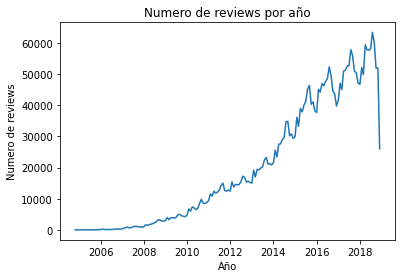

In [8]:
plt.plot(df['text'].resample('M').count())
plt.xlabel('Año')
plt.ylabel('Numero de reviews')
plt.title('Numero de reviews por año')
plt.show()

**We can see a growth until 2018 in the number of reviews, and then from there a decline in it to approximately 2014 levels.**

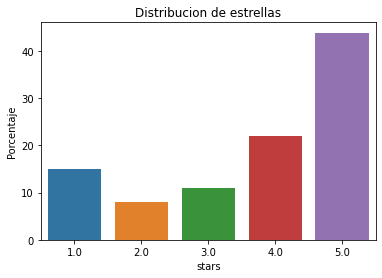

In [9]:
#Distribution of the variable stars.
ax = sns.barplot(data=df, x='stars', y='stars', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Porcentaje")
plt.title('Distribucion de estrellas')
plt.show()

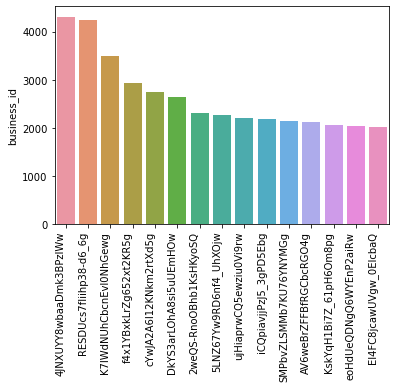

<Figure size 1440x504 with 0 Axes>

In [10]:
#Distribution of the business id variable.
business_count = df.business_id.value_counts()
business_count = business_count[business_count>2000]
ax = sns.barplot(x=business_count.index, y=business_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.figure(figsize=(20,7))
plt.tight_layout()
plt.show()

## Data filtering.

In [11]:
business_most_review = business_count.index[0:10]

In [12]:
#We are left with the top 5 business id with the most reviews.
df_filtered = df[(df.business_id==business_most_review[0]) |
        (df.business_id==business_most_review[1]) |
        (df.business_id==business_most_review[2]) | 
        (df.business_id==business_most_review[3]) |
        (df.business_id==business_most_review[4])]

In [13]:
df_filtered = df_filtered[['stars', 'text']]

## Pre processing.

In [14]:
#Converting the text to lowercase.
txt_lower = [txt.lower() for txt in df_filtered.text]
df_filtered['text']= txt_lower

In [15]:
df_filtered['positive_review'] = ""

In [16]:
#Plot reviews clasification.
stars_count = df_filtered.stars.value_counts()
print(stars_count)

5.00    7138
4.00    5301
3.00    2637
2.00    1472
1.00    1185
Name: stars, dtype: int64


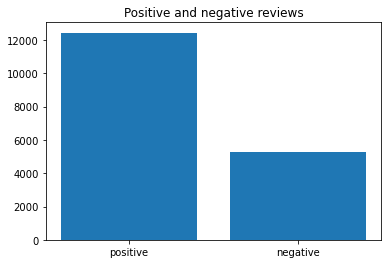


Positive count: 12439 
Negative count: 5294 


In [17]:
#Plot reviews clasification.
stars_count = df_filtered.stars.value_counts()

negative_count = stars_count[1] +  stars_count[2] + stars_count[3] 
positive_count = stars_count[4] + stars_count[5]
raiting = pd.DataFrame([{'positive_count': positive_count, 'negative_count': negative_count}])
plt.bar(['positive','negative'], raiting.values[0])
plt.title("Positive and negative reviews")
plt.show()
print(f"\nPositive count: {positive_count} \nNegative count: {negative_count} ")

In [18]:
df_filtered.reset_index(inplace=True, drop=True)

In [19]:
for row in df_filtered.itertuples(index=True):
    if row[1] >= 4:
        df_filtered.loc[row[0], 'positive_review'] = 1
    else:
        df_filtered.loc[row[0], 'positive_review'] = 0

In [20]:
df_filtered = df_filtered[['text','positive_review']]

## CLASSIFICATION.

### Select the variables.

In [130]:
x = df_filtered['text'].values
y = df_filtered['positive_review'].values

In [131]:
y = y.astype('int')

In [132]:
x = x.reshape(-1,1)
y = y.reshape(-1,1)

### Classes are balanced.

In [133]:
from imblearn.under_sampling import RandomUnderSampler

In [134]:
rus = RandomUnderSampler(random_state=0)
x, y = rus.fit_resample(x, y)

### Text cleanup.

In [135]:
from nltk.corpus import stopwords
import string
text = []
def text_clean(message):
    nopunc = [i for i in message if i not in string.punctuation]
    nopunc = [i for i in nopunc if i not in string.digits]
    nn = "".join(nopunc)
    nn = nn.lower().split()
    nostop = [words for words in nn if words not in stopwords.words('english')]
    for i in nostop:
        if int(len(i)) >=3:
            text.append(i)
    return(text)

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
cv_transformer = CountVectorizer(analyzer = text_clean)

In [ ]:
x = cv_transformer.fit_transform(x)

### Separates into train and test.

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 101)

## MODEL: Naive Bayes.

In [49]:
from sklearn.naive_bayes import MultinomialNB

In [50]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB()

In [51]:
pred_nb = nb.predict(x_test)
pred_nb

array([1, 0, 0, ..., 1, 1, 1])

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
df_confusion = pd.crosstab(y_test, pred_nb,colnames=["Predictions"], rownames=["Actual"])
print(df_confusion)
print("\n")
print(classification_report(y_test, pred_nb))

Predictions     0     1
Actual                 
0            1375   232
1             273  1297


              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1607
           1       0.85      0.83      0.84      1570

    accuracy                           0.84      3177
   macro avg       0.84      0.84      0.84      3177
weighted avg       0.84      0.84      0.84      3177



## MODEL: Random Forest.

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [56]:
pred_rf = rf.predict(x_test)

In [57]:
df_confusion = pd.crosstab(y_test, pred_rf,colnames=["Predictions"], rownames=["Actual"])
print(df_confusion)
print("\n")
print("Classification report\n",classification_report(y_test, pred_rf))

Predictions     0     1
Actual                 
0            1389   218
1             365  1205


Classification report
               precision    recall  f1-score   support

           0       0.79      0.86      0.83      1607
           1       0.85      0.77      0.81      1570

    accuracy                           0.82      3177
   macro avg       0.82      0.82      0.82      3177
weighted avg       0.82      0.82      0.82      3177



## MODEL: Logistic regression.

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
log_reg = LogisticRegression().fit(x_train, y_train)
pred_lg = log_reg.predict(x_test)

C:\Users\juamp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
df_confusion = pd.crosstab(y_test, pred_lg,colnames=["Predictions"], rownames=["Actual"])
print(df_confusion)
print("\n")
print("Classification report\n",classification_report(y_test, pred_lg))

Predictions     0     1
Actual                 
0            1349   258
1             227  1343


Classification report
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1607
           1       0.84      0.86      0.85      1570

    accuracy                           0.85      3177
   macro avg       0.85      0.85      0.85      3177
weighted avg       0.85      0.85      0.85      3177



In [72]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [64]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

In [78]:
#Logistic regression,
lr_probs = log_reg.predict_proba(x_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

#Random forest.
rf_probs = rf.predict_proba(x_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#MultinomialNB.
nb_probs = nb.predict_proba(x_test)
nb_probs =nb_probs[:, 1]
nb_auc = roc_auc_score(y_test, nb_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

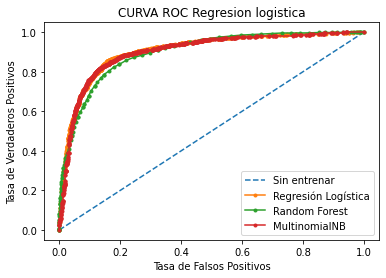

In [79]:
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Regresión Logística')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.plot(nb_fpr, nb_tpr, marker='.', label='MultinomialNB')
plt.title('CURVA ROC Regresion logistica')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.show()